# Heat Conduction

**Intputs**

- `qprime`: Linear heat generation rate ($\frac{W}{m}$)
- `mdot`: Mass flow rate ($\frac{g}{s}$)
- `Tin`: Temperature of the fuel boundary ($K$)
- `R`: Fuel radius ($m$)
- `L`: Fuel length ($m$)
- `Cp`: Heat capacity ($\frac{J}{g \cdot K}$)
- `k`: Thermal conductivity ($\frac{W}{m \cdot K}$)

**Output**

- `T`: Fuel centerline temperature ($K$)

This data set consists of 1000 points with seven inputs and one output. The data set was constructed through Latin hypercube sampling of the seven input parameters for heat conduction through a fuel rod. These samples were then used to solve for the fuel centerline temperature analytically. The geometry of the problem is illustrated in the figure below, and it is assumed volumetric heat generation is uniform radially. The problem is defined by

\begin{equation}
\frac{1}{r}\frac{d}{dr}(kr\frac{dT}{dr}) + q''' = 0,
\end{equation}

with two boundary conditions: $\frac{dT}{dr}|_{r = 0} = 0$ and $T(R) = T_{in}$. Therefore, the temperature profile in the fuel is

\begin{equation}
T(r) = \frac{q'}{4\pi k}(1 - (r / R)^2) + T_{in}.
\end{equation}

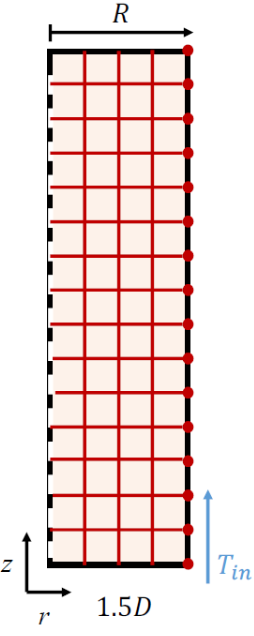

The following are a few standard packages and functions that will prove helpful while using pyMAISE along with pyMAISE-specific functionality. 

In [1]:
# Importing Packages
import time
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import uniform, randint
from sklearn.preprocessing import MinMaxScaler

# pyMAISE specific imports
import pyMAISE as mai
from pyMAISE.datasets import load_heat
from pyMAISE.preprocessing import scale_data, train_test_split, correlation_matrix

# Plot settings
matplotlib_settings = {
    "font.size": 12,
    "legend.fontsize": 11,
    "figure.figsize": (8, 8)
}
plt.rcParams.update(**matplotlib_settings)

## pyMAISE Initialization

We start by initializing pyMAISE settings and then importing the data set using `pyMAISE.datasets.load_heat()` from the pyMAISE dataset library.

In [2]:
# Initializing pyMaise settings and the problem we are solving (regression)
global_settings = mai.init(
    problem_type=mai.ProblemType.REGRESSION,   # Define a regression problem
    cuda_visible_devices="-1"                  # Use CPU only
)

# Get data
data, inputs, outputs = load_heat()

The heat conduction data set has 7 inputs

In [3]:
inputs

<xarray.DataArray (index: 1000, variable: 7)>
array([[3.59879928e+04, 2.06185816e+02, 5.73151869e+02, ...,
        3.44815496e+00, 4.09614034e+00, 9.60945479e-01],
       [3.84810558e+04, 1.92378974e+02, 5.73150960e+02, ...,
        3.43683275e+00, 4.24918181e+00, 1.01127217e+00],
       [3.91432921e+04, 2.05076928e+02, 5.73153975e+02, ...,
        3.68145722e+00, 4.23754044e+00, 9.94646131e-01],
       ...,
       [4.01365078e+04, 1.91977771e+02, 5.73151522e+02, ...,
        3.63435094e+00, 4.12297685e+00, 1.01905766e+00],
       [4.06288682e+04, 1.93001960e+02, 5.73152035e+02, ...,
        3.64753610e+00, 4.21262950e+00, 9.68979168e-01],
       [3.90566005e+04, 1.87235532e+02, 5.73153905e+02, ...,
        3.40448532e+00, 4.06543435e+00, 1.00688469e+00]])
Coordinates:
  * index     (index) int64 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999
  * variable  (variable) object 'qprime' 'mdot' 'Tin' 'R' 'L' 'Cp' 'k'

and 1 output with 1000 data points.

In [4]:
outputs

<xarray.DataArray (index: 1000, variable: 1)>
array([[1034.13378385],
       [1170.31604229],
       [1164.89356528],
       [1205.25003976],
       [1444.71866607],
       [1415.16087218],
       [1141.02596298],
       [1135.41902917],
       [1087.37893848],
       [1484.62104894],
       [1095.53986907],
       [1173.29114652],
       [1157.14848053],
       [1256.81754162],
       [1118.14237521],
       [1042.34706612],
       [1049.5434326 ],
       [1181.84317152],
       [1425.17119154],
       [1201.11399329],
...
       [1440.68291936],
       [1126.62859092],
       [1118.47511015],
       [1215.64386477],
       [1506.41447337],
       [1118.13383746],
       [1427.1010686 ],
       [1070.54469832],
       [1393.14664198],
       [1374.22902546],
       [1142.38817778],
       [1487.82931858],
       [1103.84446468],
       [1161.70719007],
       [1503.51884631],
       [1396.11284268],
       [1570.4571551 ],
       [1438.29381922],
       [1374.74521282],
       [1187.64399672]])
Coordinates:
  * index     (index) int64 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999
  * variable  (variable) object 'T'

To better understand the data here is a correlation matrix of the data.

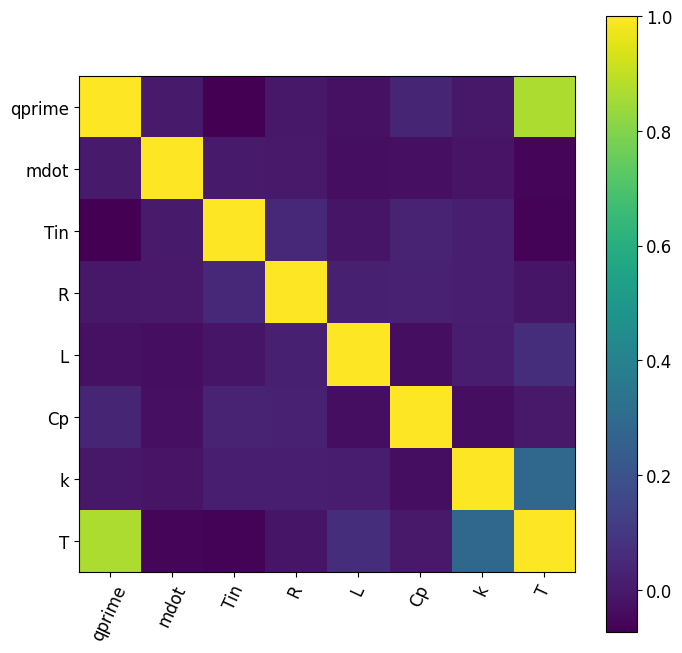

In [5]:
correlation_matrix(data)
plt.show()

As expected, there is a strong correlation between the linear heat generation rate, `prime,` and the centerline fuel temperature, `T.`

Before model training, the data is split into training/test (70% training and 30% testing) along with min-max scaling to make each feature's effect size comparable. Additionally, this can improve the performance of some models.

In [6]:
# Train test split data
xtrain, xtest, ytrain, ytest = train_test_split(data=[inputs, outputs], test_size=0.30)

# Min-Max scaling data 
xtrain, xtest, _ = scale_data(xtrain, xtest, MinMaxScaler())
ytrain, ytest, yscaler = scale_data(ytrain, ytest, MinMaxScaler())

## Model Initialization

We will examine the performance of 7 models in this data set:

- Linear regression: `Linear`,
- Lasso regression: `Lasso`,
- Support vector regression: `SVM`,
- Decision tree regression: `DT`,
- Random forest regression: `RF`,
- K-nearest neighbors regression: `KN`,
- Sequential dense neural networks: `FNN`.

For hyperparameter tuning each model, we must initialize the architecture and optimize search spaces. For all the classical models we initialize them using the scikit-learn default configurations. The FNNs are defined as sequential dense neural networks. For the input and hidden dense layers we are hyperparameter tuning the number of nodes, sublayer, and sublayer dropout rate. We are also tuning the number of hidden layers, the Adam learning rate, and batch size.

In [7]:
# Initializing all the models wanted in the model)settings variable along with neurel network archetecture/optimization hps
model_settings = {
    "models": ["Linear", "Lasso", "SVM", "DT", "RF", "KN", "FNN"],
    "FNN": {
        "structural_params": {
            "Dense_hidden": {
                "num_layers": mai.Int(min_value=0, max_value=3),
                "units": mai.Int(min_value=25, max_value=400),
                "activation": "relu",
                "kernel_initializer": "normal",
                "sublayer": mai.Choice(["Dropout_hidden", "None"]),
                "Dropout_hidden": {
                    "rate": mai.Float(min_value=0.4, max_value=0.6),
                },
            },
            "Dense_output": {
                "units": ytrain.shape[-1],
                "activation": "linear",
                "kernel_initializer": "normal",
            },
        },
        "optimizer": "Adam",
        "Adam": {
            "learning_rate": mai.Float(min_value=1e-5, max_value=0.001),
        },
        "compile_params": {
            "loss": "mean_absolute_error",
            "metrics": ["mean_absolute_error"],
        },
        "fitting_params": {
            "batch_size": mai.Choice([8, 16, 32]),
            "epochs": 50,
            "validation_split": 0.15,
        },
    },
}
# Constructing Tuner object for the search space above
tuner = mai.Tuner(xtrain, ytrain, model_settings=model_settings)

## Hyperparameter Tuning

For hyperparameter tuning the classical models, we use `pyMAISE.Tuner.random_search` with 300 iterations and 5-fold cross-validation. We do this because the classical models are relatively cheap to train, so we can better cover the hyperparameter search space. For the FNNs, we use `pyMAISE.Tuner.nn_bayesian_search` with 50 iterations and 5-fold cross-validation. We use Bayesian search with fewer configurations as the FNNs are more computationally expensive. The Bayesian search should converge on an optimal configuration within 30-50 iterations. The cross-validation ensures there is no bias in the configurations saved. The hyperparameter search spaces are outlined below.

In [8]:
# Classical Model search space
random_search_spaces = {
    "Lasso": {
        "alpha": uniform(loc=0.0001, scale=0.0099), # 0.0001 - 0.01
    },
    "DT": {
        "max_depth": randint(low=5, high=50), # 5 - 50
        "max_features": [None, "sqrt", "log2", 2, 4, 6],
        "min_samples_split": randint(low=2, high=20), # 2 - 20
        "min_samples_leaf": randint(low=1, high=20), # 1 - 20
    },
    "SVM": {
        "kernel": ["linear", "poly", "rbf", "sigmoid"],
        "degree": randint(low=1, high=5),
        "gamma": ["scale", "auto"],
    },
    "RF": {
        "n_estimators": randint(low=50, high=200), # 50 - 200
        "criterion": ["squared_error", "absolute_error", "poisson"],
        "min_samples_split": randint(low=2, high=20), # 2 - 20
        "min_samples_leaf": randint(low=1, high=20), # 1 - 20
        "max_features": [None, "sqrt", "log2", 2, 4, 6],
    },
    "KN": {
        "n_neighbors": randint(low=1, high=20), # 1 - 20
        "weights": ["uniform", "distance"],
        "leaf_size": randint(low=1, high=30), # 1 - 30
        "p": randint(low=1, high=10), # 1 - 10
    },
}

# Running the tuner for with the search algorithm desired
start = time.time()
random_search_configs = tuner.random_search(
    param_spaces=random_search_spaces, 
    n_iter=300,
    n_jobs=6,
    cv=5,
)
bayesian_search_configs = tuner.nn_bayesian_search(
    objective="r2_score",
    max_trials=50,
    cv=5,
)
print("Hyperparameter tuning took " + str((time.time() - start) / 60) + " minutes to process.")

Hyperparameter tuning took 29.920362746715547 minutes to process.


With the conclusion of hyper-parameter tuning we can see the training results of each iteration of the bayesian search.

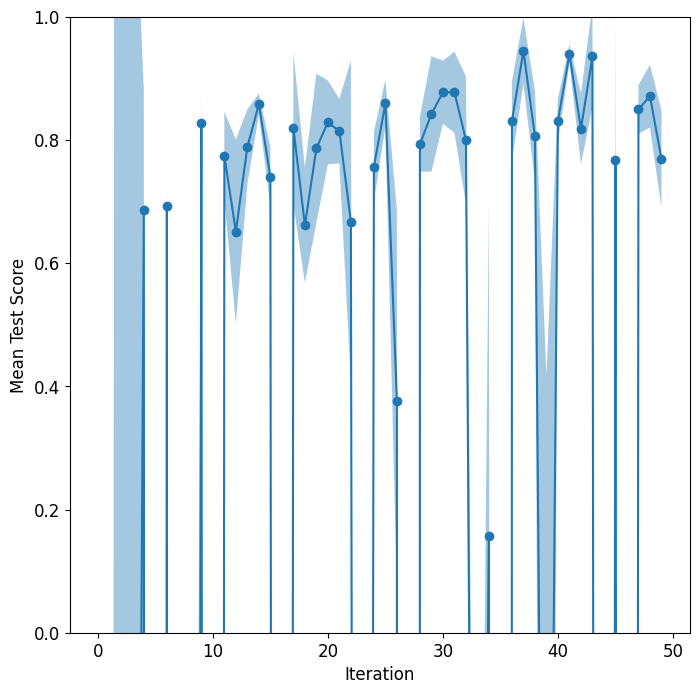

In [9]:
ax = tuner.convergence_plot(model_types="FNN")
ax.set_ylim([0, 1])
plt.show()

After about ten iterations, the Bayesian search converges on the optimal solution for this parameter space.

## Model Postprocessing

With the models tuned and the top `pyMAISE.Settings.num_configs_saved` saved, we can now pass these models to the `PostProcessor` for model comparison and analysis. We will increase the `FNN` models `epochs` for better performance.

In [10]:
postprocessor = mai.PostProcessor(
    data=(xtrain, xtest, ytrain, ytest), 
    model_configs=[random_search_configs, bayesian_search_configs], 
    new_model_settings={
        "FNN": {"fitting_params": {"epochs": 200}},
    },
    yscaler=yscaler,
)

The regression performance metrics on fuel centerline temperature are shown below.

In [11]:
postprocessor.metrics().drop("Parameter Configurations", axis=1)

,Model Types,Train R2,Train MAE,Train MAPE,Train RMSE,Train RMSPE,Test R2,Test MAE,Test MAPE,Test RMSE,Test RMSPE
20,RF,0.997154,4.986508,0.386106,8.052169,0.631222,0.994233,7.923253,0.616351,11.824369,0.918915
18,RF,0.997033,5.139566,0.397534,8.221685,0.642415,0.994039,8.098878,0.630486,12.021820,0.936141
17,RF,0.998024,4.427935,0.342536,6.709407,0.533691,0.993746,8.205877,0.637626,12.314054,0.956969
19,RF,0.997136,5.263513,0.406251,8.077905,0.635408,0.993728,8.350372,0.647859,12.331529,0.954462
16,RF,0.998684,3.552243,0.275988,5.476834,0.438886,0.993029,8.551964,0.666155,13.000574,1.011017
14,DT,0.993846,8.446816,0.650752,11.841301,0.915109,0.985220,12.827502,1.009586,18.930021,1.501253
13,DT,0.993846,8.446816,0.650752,11.841301,0.915109,0.985220,12.827502,1.009586,18.930021,1.501253
15,DT,0.996577,6.133811,0.476671,8.831676,0.699559,0.984935,12.667243,0.999214,19.111302,1.520477
11,DT,0.995777,6.739139,0.520000,9.808999,0.759180,0.984636,12.876282,1.016210,19.300072,1.535464
12,DT,0.994587,7.802882,0.601207,11.106283,0.863034,0.984309,13.410189,1.055767,19.504322,1.550309


This data set represents radial heat conduction, so we do not expect linear models to perform well. This is shown by the relatively poor performance of `Linear` and `Lasso`. The best-performing models were `RF`, `DT`, and `FNN` with test and train r-squared above 0.99. 

Using the `pyMAISE.PostProcessor.print_model`, we can see the optimal hyperparameter configurations for each model.

In [12]:
for model in ["Lasso", "DT", "RF", "KN", "FNN"]:
    postprocessor.print_model(model_type=model)
    print()

Model Type: Lasso
  alpha: 0.00028379044515601027

Model Type: DT
  max_depth: 40
  max_features: None
  min_samples_leaf: 6
  min_samples_split: 4

Model Type: RF
  criterion: poisson
  max_features: 6
  min_samples_leaf: 3
  min_samples_split: 2
  n_estimators: 138

Model Type: KN
  leaf_size: 12
  n_neighbors: 10
  p: 1
  weights: distance

Model Type: FNN
  Structural Hyperparameters
    Layer: Dense_hidden_0
      units: 251
      sublayer: None
    Layer: Dense_hidden_1
      units: 184
      sublayer: None
    Layer: Dense_hidden_2
      units: 47
      sublayer: None
    Layer: Dense_output_0
  Compile/Fitting Hyperparameters
    Adam_learning_rate: 0.0008821712781015931
    batch_size: 8
Model: "FNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_hidden_0 (Dense)      (None, 251)               2008      
                                                                 
 Dense_hidden_1 (

Below is the network plot for the FNN.

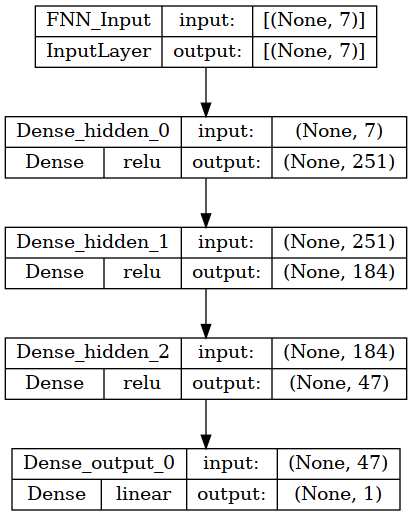

In [13]:
postprocessor.nn_network_plot(
    to_file="./supporting/heat_conduction_network.png",
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True,
    show_layer_activations=True,
)

To visualize the performance of these models, we can use the `pyMAISE.PostProcessor.diagonal_validation_plot` functions to produce diagonal validation plots.

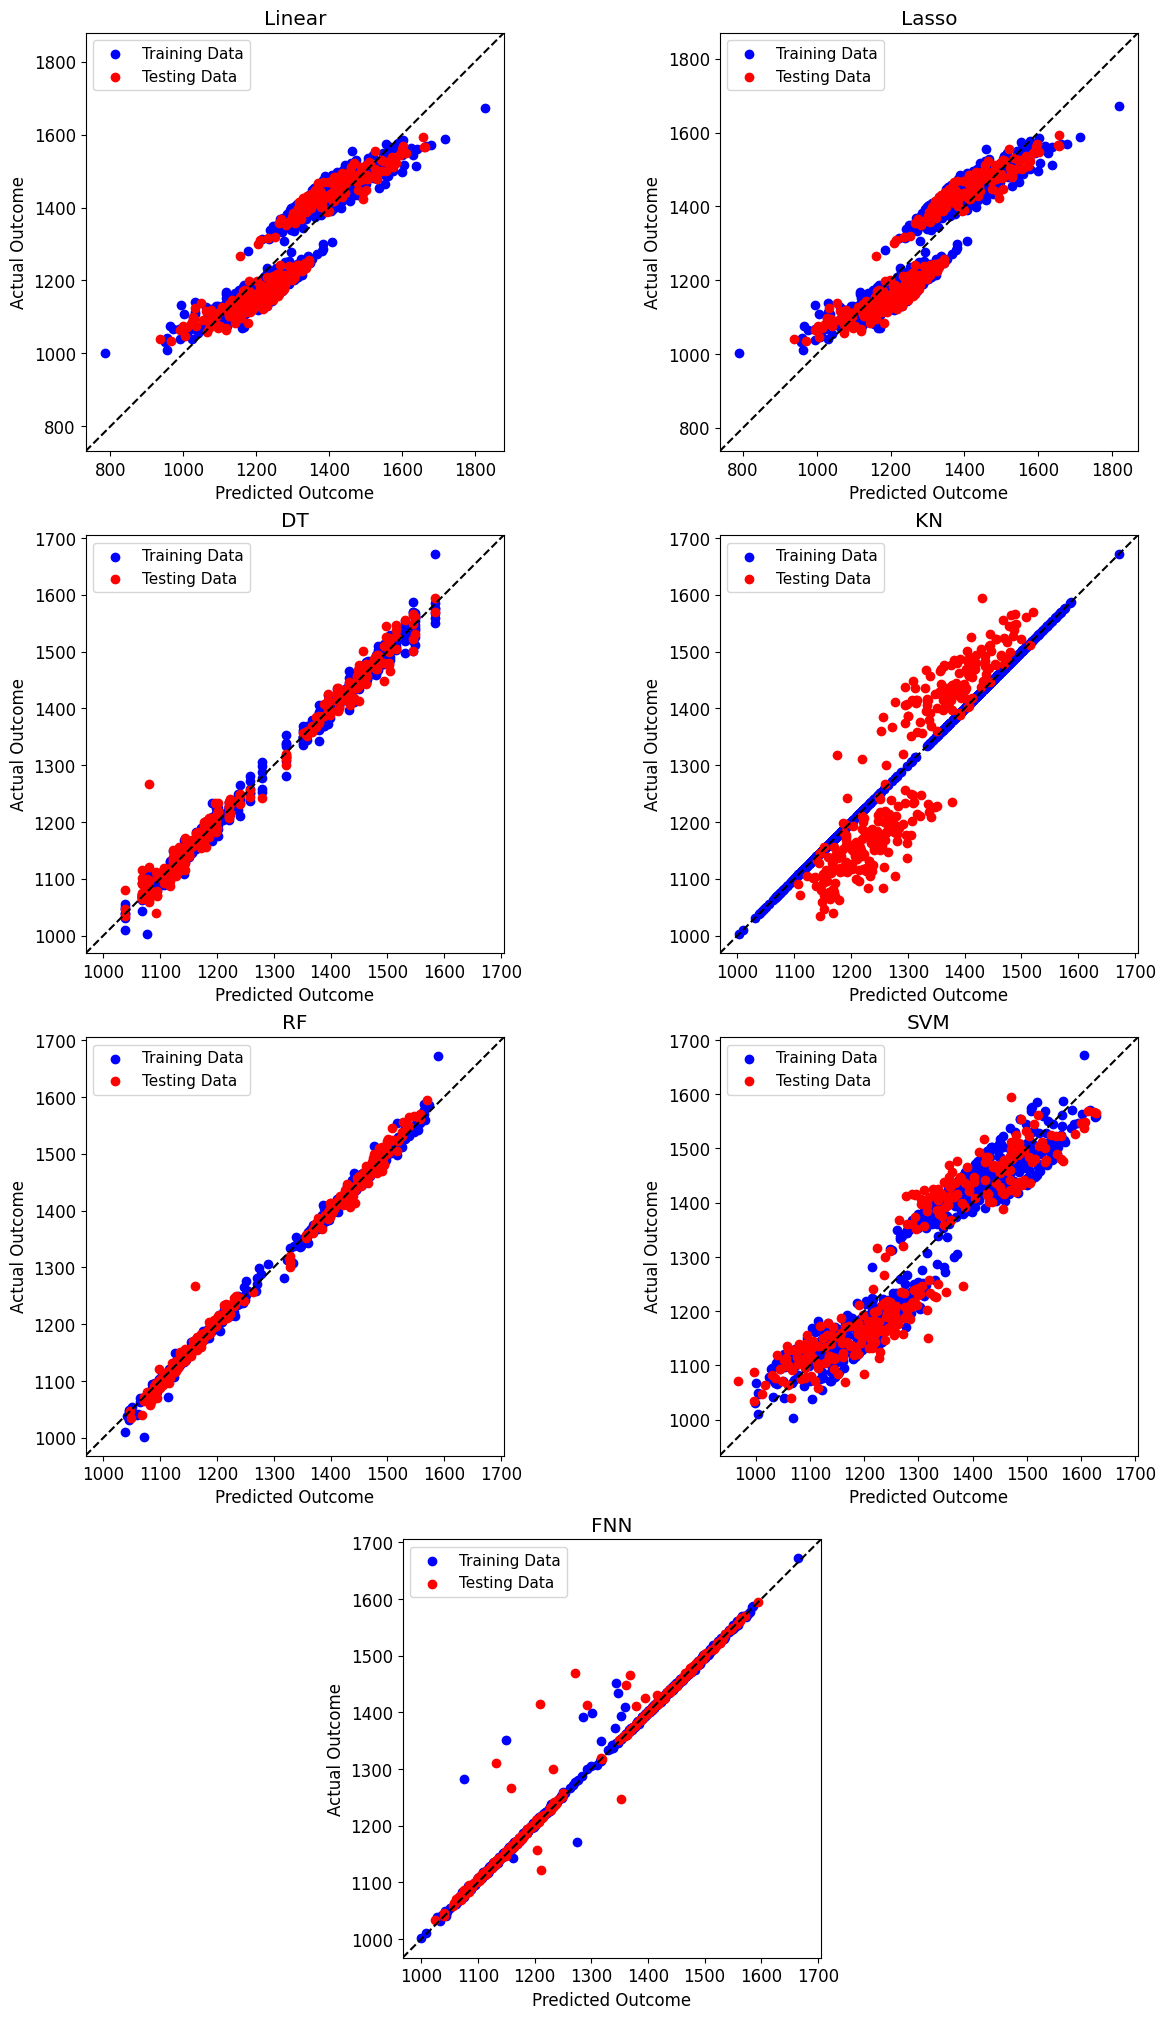

In [14]:
models = np.array([["Linear", "Lasso"], ["DT", "KN"], ["RF", "SVM"]])
fig = plt.figure(figsize=(15, 25))
gs = fig.add_gridspec(4, 2)
for i in range(models.shape[0]):
    for j in range(models.shape[1]):
        ax = fig.add_subplot(gs[i, j])
        ax = postprocessor.diagonal_validation_plot(model_type=models[i, j])
        ax.set_title(models[i, j])
ax = fig.add_subplot(gs[3, :])
ax = postprocessor.diagonal_validation_plot(model_type="FNN")
ax.set_title("FNN")
plt.show()

The performance differences between `RF`/`DT` with the other models are apparent along with the overfitting of `KN`. The `RF` and `DT` predictions are closely spread along $y=x$ while the `KN` test predictions are over-predicted at lower temperatures and under-predicted at higher temperatures.

Similarly, the `pyMAISE.PostProcessor.validation_plot` function produces validation plots showing each prediction's absolute relative error.

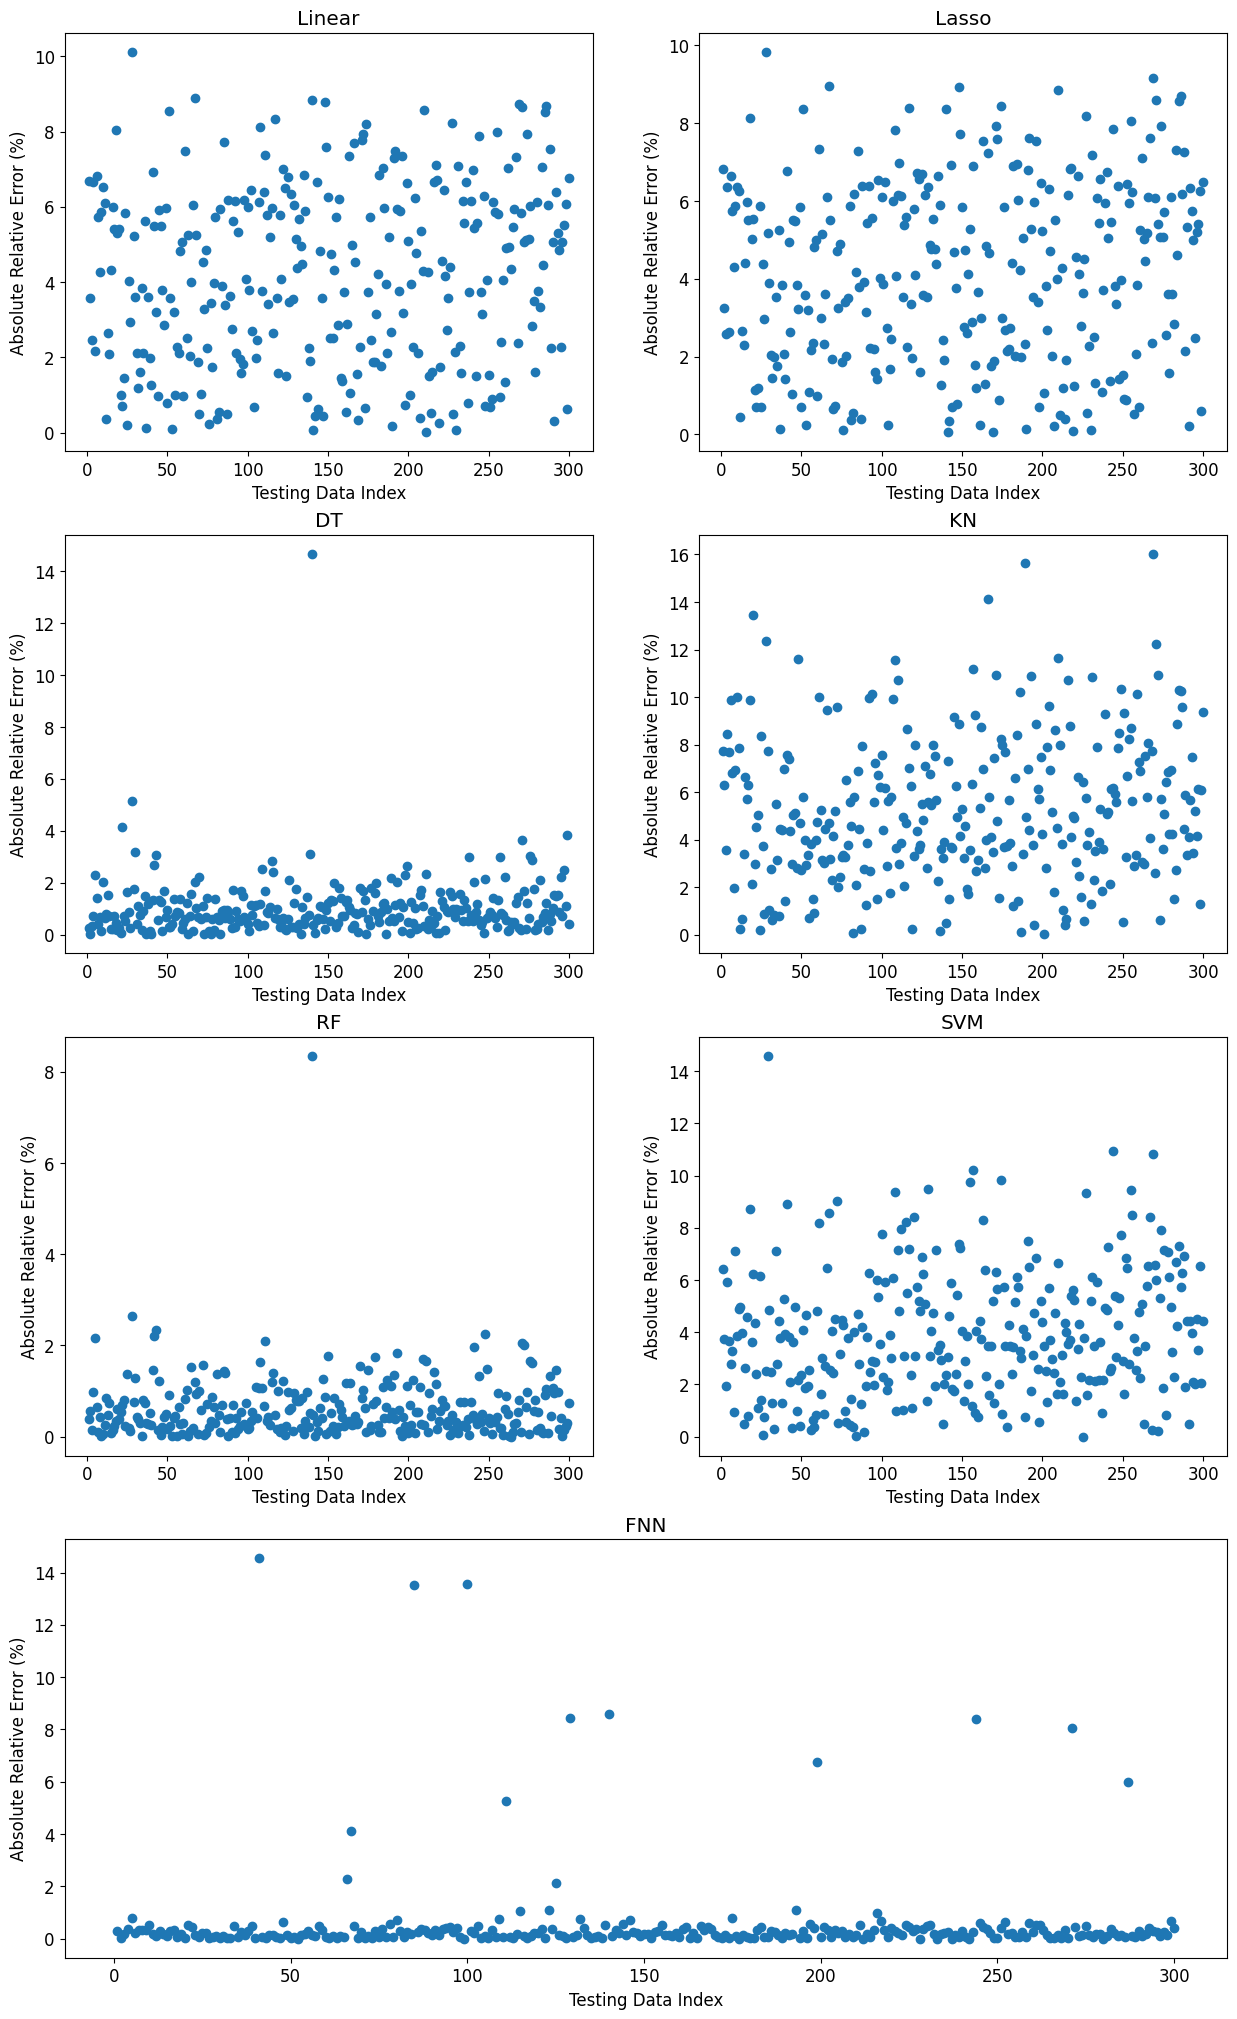

In [15]:
fig = plt.figure(figsize=(15, 25))
gs = fig.add_gridspec(4, 2)
for i in range(models.shape[0]):
    for j in range(models.shape[1]):
        ax = fig.add_subplot(gs[i, j])
        ax = postprocessor.validation_plot(model_type=models[i, j])
        ax.set_title(models[i, j])
ax = fig.add_subplot(gs[3, :])
ax = postprocessor.validation_plot(model_type="FNN")
ax.set_title("FNN")
plt.show()

The performance of the models is best represented by the magnitudes observed on the y-axis; however, even `RF` gets as high as $>10.0\%$ error. 

Finally, the most performant `FNN` learning curve is shown by `pyMAISE.PostProcessor.nn_learning_plot`.

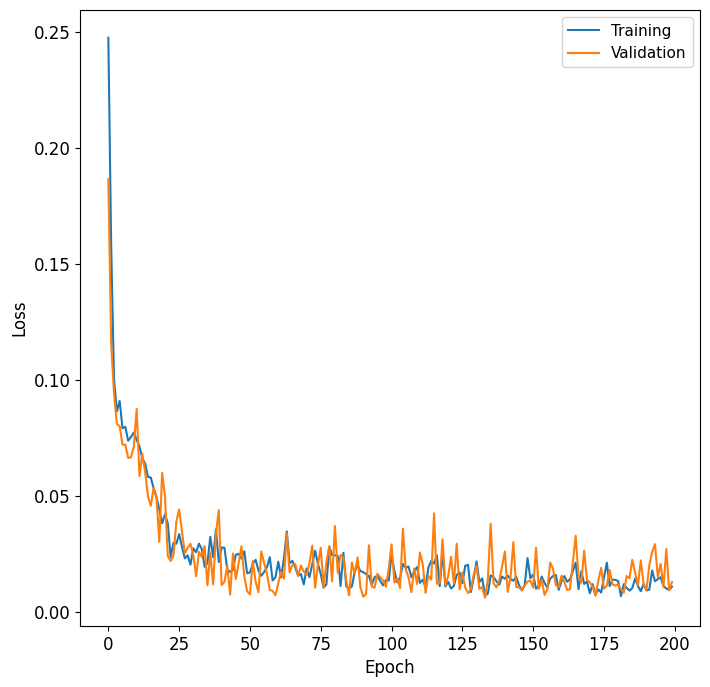

In [16]:
postprocessor.nn_learning_plot()
plt.show()

From the learning curve we can see the top performing neural network based on test $R^2$ is slightly overfit with validation above training.

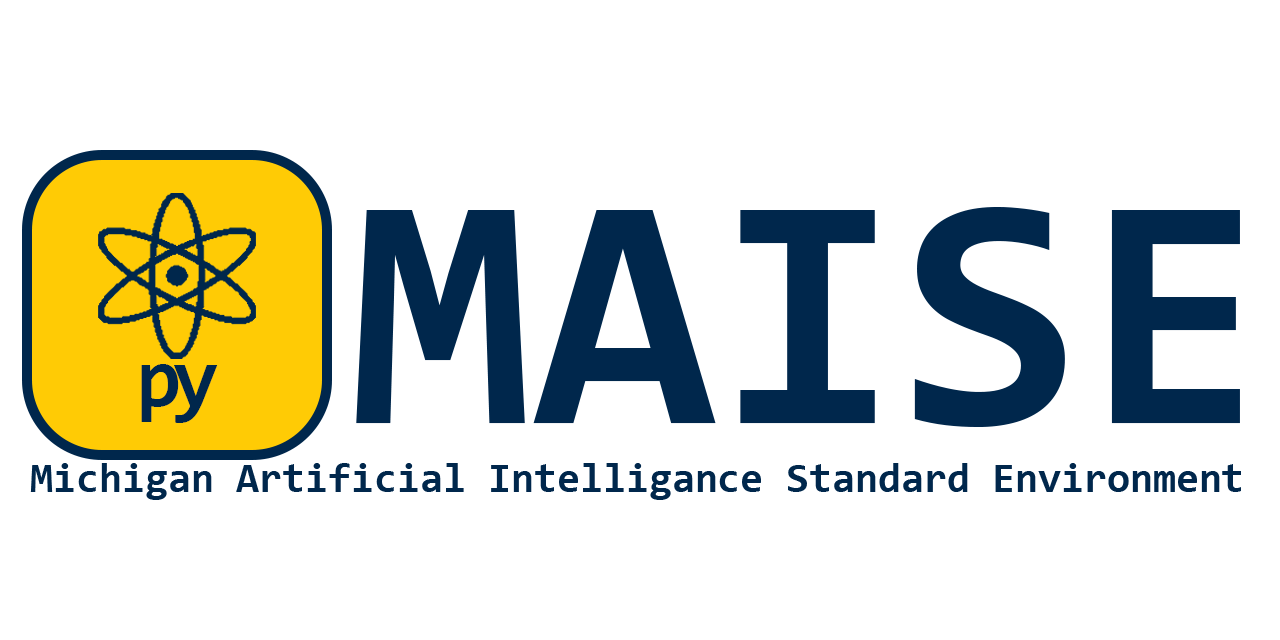